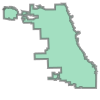

In [1]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd
from tqdm import tqdm
# Import the functions presented here :
import gpd_lite_toolbox as glt

def load_data():

    pkl_path = "data/chicago.pkl"
    if os.path.exists(pkl_path):
        df = pickle.load(open(pkl_path, "rb"))
        return df

    df = pd.concat([
        # pd.read_csv('data/chicago/Chicago_Crimes_2001_to_2004.csv',error_bad_lines=False),
        # pd.read_csv('data/chicago/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False),
        # pd.read_csv('data/chicago/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False),
        pd.read_csv('data/chicago/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
    ], ignore_index=False, axis=0)
    df.drop_duplicates(subset=["ID"], keep='first', inplace=True)

    print("After drop_duplicates", df.shape)
    df = df[["Date", "Latitude", "Longitude", "Primary Type"]]
    df.columns = ["ts", "lat", "long", "type"]
    df = df.dropna()
    df.ts = pd.to_datetime(df.ts, format='%m/%d/%Y %I:%M:%S %p').astype(np.int64) // 10**9
    print("After dropna", df.shape)
    df = df.loc[df["ts"] >= 1420070400]
    df = df.loc[df["ts"] <= 1483228800]

    df["lat"] = df["lat"].apply(lambda x: float(x))
    df["long"] = df["long"].apply(lambda x: float(x))

    print("After minmax ts clip", df.shape)
    chicago = gpd.read_file("data/chicago/city/geo_export_41e84a0e-a158-44f2-abe6-a52f78662352.shp")
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
    chicago_mask = gdf.geometry.within(chicago.loc[0, 'geometry'])
    chicago_gdf = gdf[chicago_mask]
    print("After chicago clip", chicago_gdf.shape)
    
    neighborhoods = gpd.read_file("data/chicago/neighborhoods/geo_export_265e79d9-e1f1-47fc-856d-1c753cbbe120.shp")
    neigh_gdf = gpd.sjoin(chicago_gdf, neighborhoods, how="inner", op='within')
    neigh_gdf = neigh_gdf[["ts", "lat", "long", "pri_neigh", "type"]]
    neigh_gdf.columns = ["ts", "lat", "long", "neigh", "type"]
    
    print("After neighborhood join", neigh_gdf.shape)
    
    pickle.dump(neigh_gdf, open(pkl_path, "wb"))
    

    return neigh_gdf

chicago = gpd.read_file("data/chicago/city/geo_export_41e84a0e-a158-44f2-abe6-a52f78662352.shp")
chicago.geometry[0]

In [2]:
chicago.head()

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1.0,6.450277e+09,845282.931362,(POLYGON ((-87.93514385942143 42.0008891160732...


In [3]:
gdf = load_data()

In [4]:
gdf.head()

,ts,lat,long,neigh,type
0,1462318800,41.864073,-87.706819,North Lawndale,BATTERY
201,1457950500,41.854753,-87.711234,North Lawndale,BURGLARY
210,1461324060,41.859931,-87.709139,North Lawndale,WEAPONS VIOLATION
244,1462327680,41.867265,-87.713917,North Lawndale,ASSAULT
287,1462345200,41.866202,-87.723080,North Lawndale,PUBLIC PEACE VIOLATION


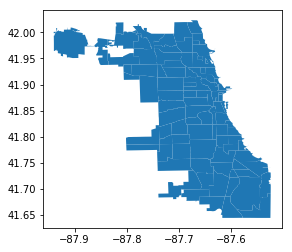

In [5]:
neighborhoods = gpd.read_file("data/chicago/neighborhoods/geo_export_265e79d9-e1f1-47fc-856d-1c753cbbe120.shp")
neighborhoods.plot()

In [6]:
gdf = gdf.sort_index()
gdf.ts = pd.to_datetime(gdf.ts, errors='coerce', unit="s")
gdf["ts_index"] = gdf["ts"]
gdf = gdf.set_index("ts_index").sort_index()
bins_dt = pd.date_range(start="2015-01-01", end="2017-01-01", normalize=True, freq="D")
bins_str = bins_dt.astype(str).values
labels = ['({}, {})'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
gdf['timebin'] = pd.cut(gdf.ts.astype(np.int64)//10**9,
                   bins=bins_dt.astype(np.int64)//10**9,
                   labels=labels,
                   right=False
                   )
assert not np.any(gdf["timebin"].isna().values) # should be empty

gdf.head()

,ts,lat,long,neigh,type,timebin
ts_index,,,,,,
2015-01-01,2015-01-01,41.752886,-87.572350,South Shore,CRIM SEXUAL ASSAULT,"(2015-01-01, 2015-01-02)"
2015-01-01,2015-01-01,41.837702,-87.720709,Little Village,OFFENSE INVOLVING CHILDREN,"(2015-01-01, 2015-01-02)"
2015-01-01,2015-01-01,41.783978,-87.692306,Chicago Lawn,OFFENSE INVOLVING CHILDREN,"(2015-01-01, 2015-01-02)"
2015-01-01,2015-01-01,41.806165,-87.657610,New City,SEX OFFENSE,"(2015-01-01, 2015-01-02)"
2015-01-01,2015-01-01,41.735348,-87.607217,Chatham,DECEPTIVE PRACTICE,"(2015-01-01, 2015-01-02)"


In [7]:
list_neighborhoods = gdf.neigh.unique().tolist()
list_types = gdf.type.unique().tolist()
list_timebins = gdf.timebin.unique().tolist()

neigh2idx = {}
idx2neigh = {}
type2idx = {}
idx2type = {}
timebin2idx = {}
idx2timebin = {}

for idx, neigh in enumerate(list_neighborhoods):
    neigh2idx[neigh] = idx
    idx2neigh[idx] = neigh
    
for idx, typ in enumerate(list_types):
    type2idx[typ] = idx
    idx2type[idx] = typ

for idx, timebin in enumerate(list_timebins):
    timebin2idx[timebin] = idx
    idx2timebin[idx] = timebin

num_neighs = len(list_neighborhoods)
num_types = len(list_types)
num_timebins = len(list_timebins)

y = np.zeros((num_timebins, num_neighs, num_types))
y.shape

(731, 98, 33)

In [8]:
groups = gdf.groupby(by=["timebin", "neigh", "type"]).size()
keys = groups.keys()
values = groups.values
num_values = len(values)
num_values

277163

In [9]:
for i in tqdm(range(num_values)):
    timebin, neigh, typ = keys[i]
    cnt = values[i]
    idx_timebin = timebin2idx[timebin]
    idx_neigh = neigh2idx[neigh]
    idx_type = type2idx[typ]
    y[idx_timebin, idx_neigh, idx_type] = cnt
    

100%|██████████| 277163/277163 [00:04<00:00, 67448.14it/s]


In [10]:
y

array([[[2., 4., 1., ..., 0., 0., 0.],
        [3., 6., 2., ..., 0., 0., 0.],
        [0., 3., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.